# Testing DoWhy's Limits

In [1]:
# Imports

import numpy as np
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Instrumental Variable Basic Example

![Instrumental_Variable](./testing_limits_figures/image.png)

### Continuous Variables

In [2]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- Everything working as expected

In [3]:
# Build dataset
data = pd.DataFrame({
    'U': ability,
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,U,voucher,education,income
0,-0.149949,2.845915,10.355989,50.344990
1,3.471917,1.282361,13.355771,68.222806
2,-1.292523,1.171093,5.069276,34.410506
3,0.415526,1.913118,8.292184,37.779499
4,-2.486772,3.988727,10.865578,47.829005


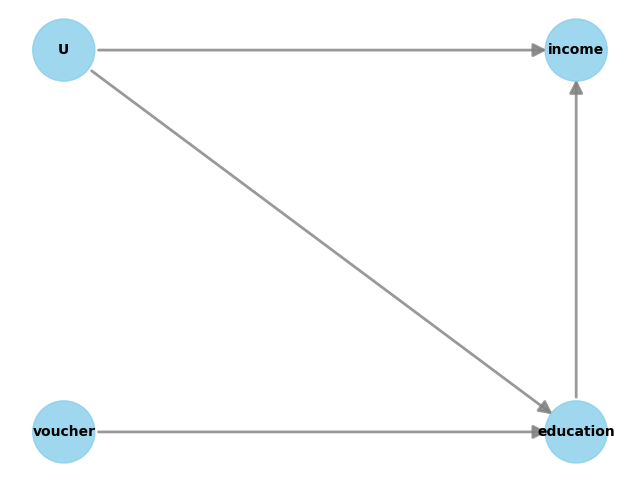

In [4]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [5]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [6]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.88284920895925
New effect:-0.00041753913249706895
p value:0.98



In [7]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.9724223776853194
New effect:0.03046284716632649
p value:0.8600000000000001



#### `Ability` as an unobserved confounder

- Everything working as expected
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [8]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,2.845915,10.355989,50.344990
1,1.282361,13.355771,68.222806
2,1.171093,5.069276,34.410506
3,1.913118,8.292184,37.779499
4,3.988727,10.865578,47.829005


C:\Users\lucas\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


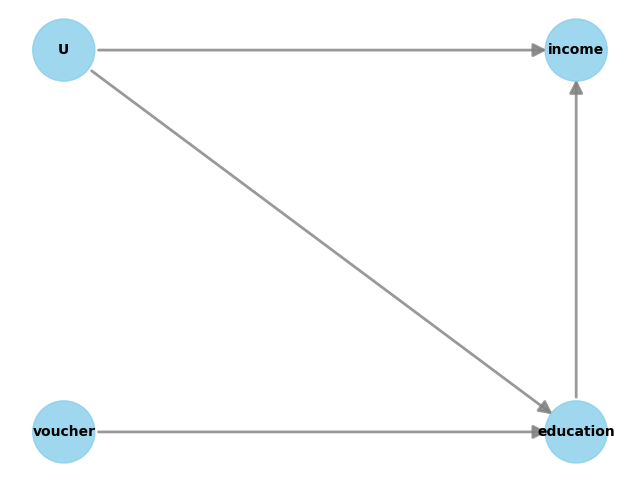

In [9]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [10]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [11]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.9724223776853194
New effect:-0.008330265922014213
p value:0.94



### Discrete Variables

- Function as continuous variables

In [12]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher


# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- Everything working as expected

In [13]:
# Build dataset
data = pd.DataFrame({
    'U': dowhy.datasets.convert_continuous_to_discrete(ability),
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': dowhy.datasets.convert_continuous_to_discrete(education),
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,U,voucher,education,income
0,-3,0,3,16
1,-4,2,4,21
2,0,3,12,63
3,3,1,11,63
4,-3,0,2,18


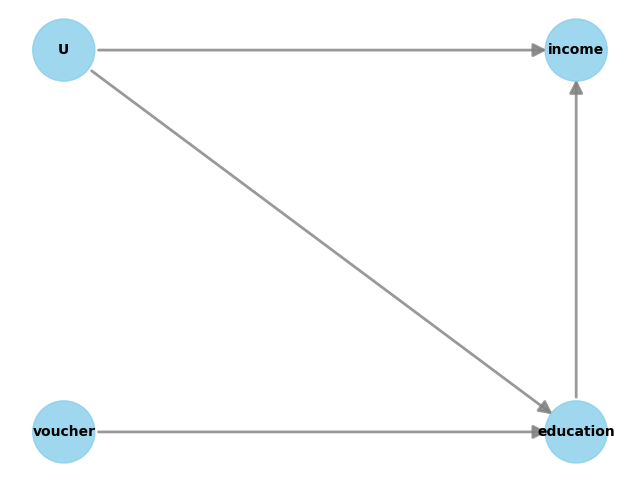

In [14]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [15]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [16]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.039401034374077
New effect:0.0011918083463973517
p value:0.96



In [17]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.935679774170303
New effect:-0.04437200681060188
p value:0.94



#### `Ability` as an unobserved confounder

- Everything working as expected
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [18]:
# Build dataset
data = pd.DataFrame({
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': dowhy.datasets.convert_continuous_to_discrete(education),
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,voucher,education,income
0,0,3,16
1,2,4,21
2,3,12,63
3,1,11,63
4,0,2,18


C:\Users\lucas\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


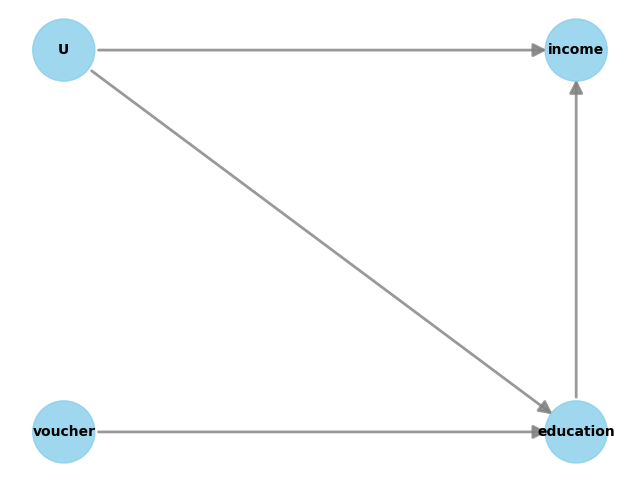

In [19]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [20]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [21]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.935679774170303
New effect:-0.033074145008003014
p value:0.88



### Discrete Variables (binary treatment)

In [22]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher
education = np.where(education < education.mean(), 0, 1)

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- IV method only works depending on the data

In [23]:
# Build dataset
data = pd.DataFrame({
    'U': dowhy.datasets.convert_continuous_to_discrete(ability),
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': education,
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,U,voucher,education,income
0,0,1,0,6
1,0,2,1,20
2,0,2,0,6
3,1,0,0,16
4,4,1,1,20


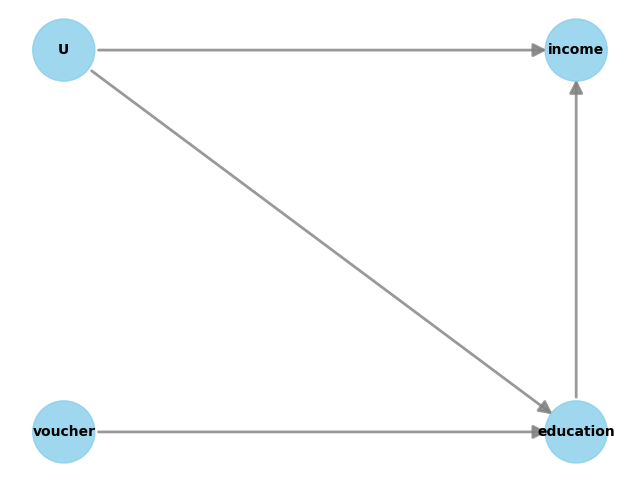

In [24]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [25]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [26]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.4526556796022
New effect:-0.012922262108315258
p value:0.98



In [27]:
# Choose the first estimand: using Propensity Score Stratification

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.196543888802595
New effect:0.01905237335103651
p value:0.98



In [28]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- IV method works depending on the data
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [29]:
# Build dataset
data = pd.DataFrame({
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': education,
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,voucher,education,income
0,1,0,6
1,2,1,20
2,2,0,6
3,0,0,16
4,1,1,20


C:\Users\lucas\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


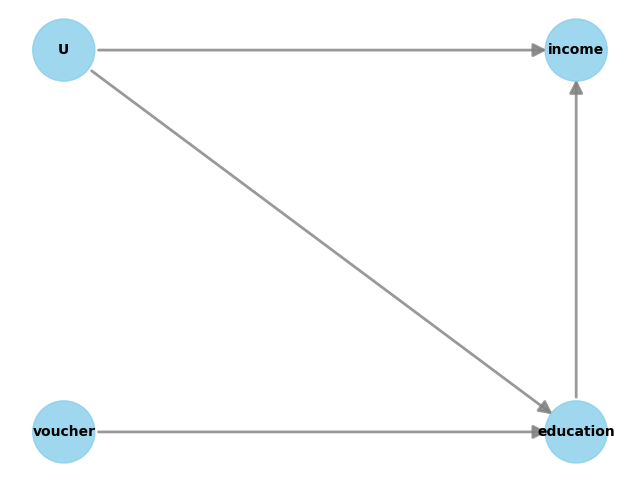

In [30]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [31]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [32]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

### All binary variables

In [33]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education
         
ability, voucher, education, income = map(lambda x: np.where(x < x.mean(), 0, 1), [ability, voucher, education, income])

#### Without latent variables

- In this scenario the IV method worked for some reason

In [34]:
# Build dataset
data = pd.DataFrame({
    'U': dowhy.datasets.convert_continuous_to_discrete(ability),
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': education,
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,U,voucher,education,income
0,1,0,0,1
1,1,1,1,1
2,1,1,1,1
3,1,0,1,1
4,1,0,0,0


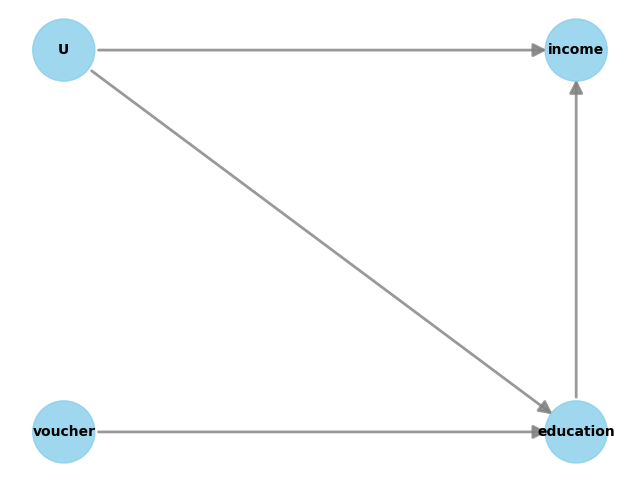

In [35]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [36]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [37]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.7035732607850711
New effect:0.00040387604755310225
p value:0.98



In [38]:
# Choose the first estimand: using Propensity Score Stratification

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.7031507860922146
New effect:-0.00301219155251611
p value:0.96



In [39]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- In this scenario the IV method works for some reason
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [40]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,0,0,1
1,1,1,1
2,1,1,1
3,0,1,1
4,0,0,0


C:\Users\lucas\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


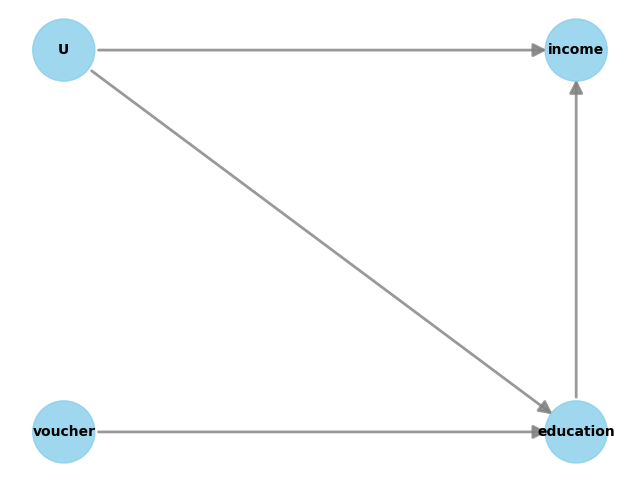

In [41]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [42]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [43]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

### Binary treatment and outcome, discrete IV and confounder

In [44]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)
ability = dowhy.datasets.convert_continuous_to_discrete(ability)

# instrument
voucher = np.random.normal(2, 1, size=n_points)
voucher = dowhy.datasets.convert_continuous_to_discrete(voucher)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education
         
education, income = map(lambda x: np.where(x < x.mean(), 0, 1), [education, income])

#### Without latent variables

- In this scenario the IV method worked for some reason

In [45]:
# Build dataset
data = pd.DataFrame({
    'U': ability,
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,U,voucher,education,income
0,-3,0,0,0
1,2,2,1,1
2,0,2,1,1
3,-2,1,0,0
4,4,2,1,1


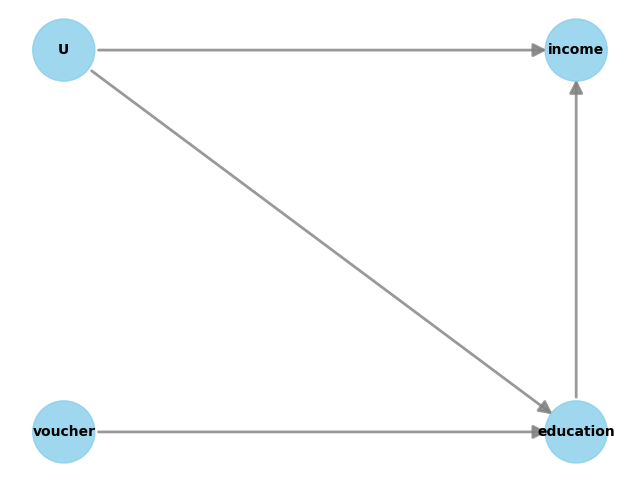

In [46]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [47]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [48]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.6323052144652928
New effect:-0.0038329561793032578
p value:0.84



In [49]:
# Choose the first estimand: using Propensity Score Stratification

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.5471839614660952
New effect:0.00022894300687270017
p value:0.8999999999999999



In [50]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- In this scenario the IV method works for some reason
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [51]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,0,0,0
1,2,1,1
2,2,1,1
3,1,0,0
4,2,1,1


C:\Users\lucas\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


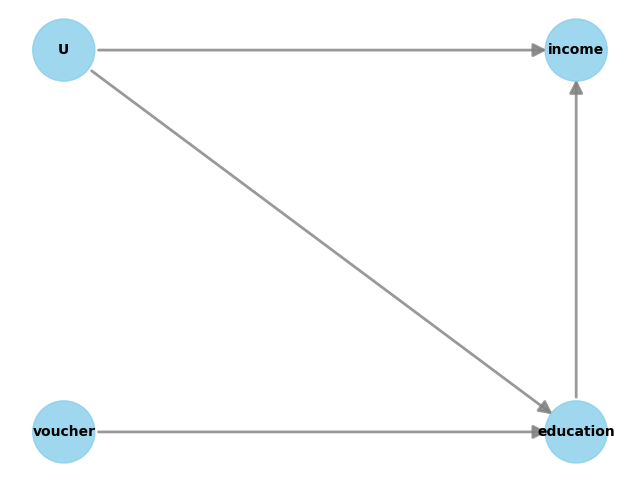

In [52]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [53]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [54]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

### Discrete Variables (binary outcome)

In [55]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)
ability = dowhy.datasets.convert_continuous_to_discrete(ability)

# instrument
voucher = np.random.normal(2, 1, size=n_points)
voucher = dowhy.datasets.convert_continuous_to_discrete(voucher)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher
education = dowhy.datasets.convert_continuous_to_discrete(education)

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education
         
income = np.where(income < income.mean(), 0, 1)

#### Without latent variables

- In this scenario the IV method worked for some reason

In [56]:
# Build dataset
data = pd.DataFrame({
    'U': ability,
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,U,voucher,education,income
0,0,4,11,1
1,0,3,10,1
2,-8,3,3,0
3,-1,2,7,0
4,0,2,10,1


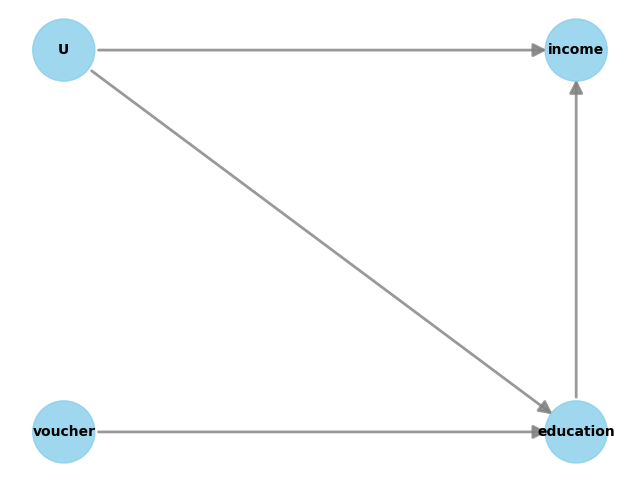

In [57]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [58]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [59]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:0.10543752503233958
New effect:0.0004607369291304958
p value:0.8600000000000001



In [60]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- In this scenario the IV method works for some reason
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [61]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,4,11,1
1,3,10,1
2,3,3,0
3,2,7,0
4,2,10,1


C:\Users\lucas\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


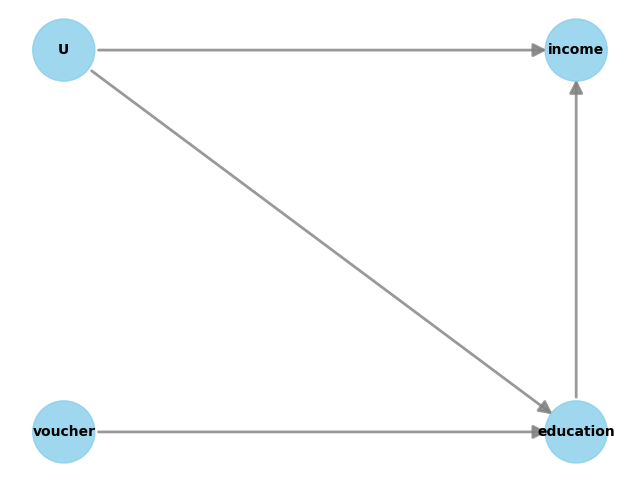

In [62]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [63]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [64]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,